<a href="https://colab.research.google.com/github/rmlessa/projeto_final/blob/main/projeto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Perguntas de Negócio

1. A renda média do bairro que recebe o abastecimento está diretamente ligada a qualidade da água fornecida?

2. A densidade populacional por bairro está relacionada com a qualidade da água fornecida?

3. Quais bairros de Manaus necessitam de tratamento de água adicional?


**Missão de hoje: **

1. Limpar os dados de 2018 a 2020 e juntar os datasets separados por ano

2. Criar uma coluna no dataset para representar coliformes fecais como ausente e presente sendo que ausente será igual a 0 e presente será igual a 1

3. Verificar a extratificação da porcentagem de coliformes presentes por bairro

In [105]:
#instala o pyspark
!pip install pyspark
#instala matplotlib
!pip install matplotlib

In [106]:
#importa bibliotecas que serão utilizadas
import pandas as pd
import sqlite3
import matplotlib as mat
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import monotonically_increasing_id #incrementa indice dos dataframes pyspark
from pyspark.sql.functions import lit
from pyspark.sql.functions import trim
from functools import reduce
from pyspark.sql import DataFrame

In [107]:
#monta o google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
#cria sessão spark no colab para realizar a extração dos dados dos arquivos countries.csv e flags.csv
if __name__ == '__main__':
    scSpark = SparkSession \
        .builder \
        .appName("etl") \
        .getOrCreate()

In [109]:
#salva o caminho onde o arquivo csv para o ano de 2018 está
analise_agua_2018 = '/content/drive/MyDrive/01 - AQUISIÇÃO DE DADOS/Projeto_Final/2amostras_de_vigilancia_parametros_basicos_anual_2018.csv'

In [110]:
#salva o caminho onde o arquivo csv para o ano de 2019 está
analise_agua_2019 = '/content/drive/MyDrive/01 - AQUISIÇÃO DE DADOS/Projeto_Final/2amostras_de_vigilancia_parametros_basicos_anual_2019.csv'

In [111]:
#salva o caminho onde o arquivo csv para o ano de 2020 está
analise_agua_2020 = '/content/drive/MyDrive/01 - AQUISIÇÃO DE DADOS/Projeto_Final/2amostras_de_vigilancia_parametros_basicos_anual_2020.csv'

In [112]:
#salva o caminho onde o arquivo csv dos dados socioeconômicos estão
dados_soc_eco =  '/content/drive/MyDrive/01 - AQUISIÇÃO DE DADOS/Projeto_Final/DADOS_SOCIOECONOMICOS_BAIRROS_MANAUS.CSV'

In [113]:
#dataframe pyspark para receber dados dos arquivos .csv

#dataset com dados de análises de águas feitas nos municípios brasileiros 2018
session_2018 = scSpark.read.csv(analise_agua_2018, header=True, encoding="ISO-8859-1" ,sep=";").cache() #armazena o resultado em cache para melhor desempenho
print('Total de Registros em 2018.csv = {}'.format(session_2018.count()))
session_2018.show()

Total de Registros em 2018.csv = 2677498
+-----------------+--------+--------------------+--------------------+--------------------+---------------+--------------------+------------------------+--------------------------+------------------------+--------------------+-----------------+--------------------+--------------------+------------------------------+--------------------+--------------------+-----+---+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|REGIAO_GEOGRAFICA|SIGLA_UF|   REGIONAL_DE_SAUDE|      NOME_MUNICIPIO|         CODIGO_IBGE| NUMERO_AMOSTRA|       MOTIVO_COLETA|TIPO_FORMA_ABASTECIMENTO|CODIGO_FORMA_ABASTECIMENTO|NOME_FORMA_ABASTECIMENTO| Tipo da Instituição|Sigla Instituição|

In [114]:
#dataframe pyspark para receber dados dos arquivos .csv

#dataset com dados de análises de águas feitas nos municípios brasileiros 2019
session_2019 = scSpark.read.csv(analise_agua_2019, header=True, encoding="ISO-8859-1" ,sep=";").cache() #armazena o resultado em cache para melhor desempenho
print('Total de Registros em 2019.csv = {}'.format(session_2019.count()))
session_2019.show()

Total de Registros em 2019.csv = 2836968
+-----------------+--------+--------------------+--------------------+--------------------+---------------+--------------------+------------------------+--------------------------+------------------------+--------------------+-----------------+--------------------+--------------------+------------------------------+--------------------+--------------------+-----+---+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|REGIAO_GEOGRAFICA|SIGLA_UF|   REGIONAL_DE_SAUDE|      NOME_MUNICIPIO|         CODIGO_IBGE| NUMERO_AMOSTRA|       MOTIVO_COLETA|TIPO_FORMA_ABASTECIMENTO|CODIGO_FORMA_ABASTECIMENTO|NOME_FORMA_ABASTECIMENTO| Tipo da Instituição|Sigla Instituição|

In [115]:
#dataframe pyspark para receber dados dos arquivos .csv

#dataset com dados de análises de águas feitas nos municípios brasileiros 2020
session_2020 = scSpark.read.csv(analise_agua_2020, header=True, encoding="ISO-8859-1" ,sep=";").cache() #armazena o resultado em cache para melhor desempenho
print('Total de Registros em 2020.csv = {}'.format(session_2020.count()))
session_2020.show()

Total de Registros em 2020.csv = 2125798
+-----------------+--------+--------------------+--------------------+--------------------+---------------+--------------------+------------------------+--------------------------+------------------------+--------------------+-----------------+--------------------+--------------------+------------------------------+--------------------+--------------------+-----+---+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|REGIAO_GEOGRAFICA|SIGLA_UF|   REGIONAL_DE_SAUDE|      NOME_MUNICIPIO|         CODIGO_IBGE| NUMERO_AMOSTRA|       MOTIVO_COLETA|TIPO_FORMA_ABASTECIMENTO|CODIGO_FORMA_ABASTECIMENTO|NOME_FORMA_ABASTECIMENTO| Tipo da Instituição|Sigla Instituição|

In [116]:
#dataframe pyspark para receber dados dos arquivos .csv

#dados socioeconômicos dos bairros de Manaus
dados_bairros_manaus = scSpark.read.csv(dados_soc_eco, header=True, encoding="ISO-8859-1" ,sep=";").cache() #armazena o resultado em cache para melhor desempenho
print('Total de Registros.csv = {}'.format(dados_bairros_manaus.count()))
dados_bairros_manaus.show()

Total de Registros.csv = 63
+-------+------------+--------------------+-------------------+-----------------------+-----------------+-------------+---------------------+
|Column1|    ZONA_ADM|              BAIRRO|POPULACAO_IBGE_2010|POPULACAO_ESTIMADA_2020|RENDA_MENSAL_2010|QTD_ELEITORES|PERIMETRO_PMM_2010_HA|
+-------+------------+--------------------+-------------------+-----------------------+-----------------+-------------+---------------------+
|      5|  CENTRO-SUL|        ADRIANOPOLIS|               8847|                  10897|             4824|         8709|               248,45|
|      6|  CENTRO-SUL|              ALEIXO|              20655|                  25441|             4930|        16725|               618,34|
|      0|CENTRO-OESTE|            ALVORADA|              64621|                  79595|             1171|        49752|               553,18|
|     12|       LESTE|      ARMANDO MENDES|              28288|                  34843|              802|        19342| 

In [117]:
#remover espaço em branco do valor das colunas

print("Removendo espaços em branco à esquerda e a direita das colunas REGIÃO_GEOGRAFICA, NOME_MUNICIPIO e AREA")

#2018
session_2018 = session_2018.withColumn("REGIAO_GEOGRAFICA", trim(col="REGIAO_GEOGRAFICA"))
session_2018 = session_2018.withColumn("NOME_MUNICIPIO", trim(col="NOME_MUNICIPIO"))
session_2018 = session_2018.withColumn("CATEGORIA_AREA", trim("CATEGORIA_AREA"))
session_2018 = session_2018.withColumn("AREA", trim(col="AREA"))
session_2018 = session_2018.withColumn("ZONA", trim(col="ZONA"))
session_2018 = session_2018.withColumn("RESULTADO", trim(col="RESULTADO"))

#2019
session_2019 = session_2019.withColumn("REGIAO_GEOGRAFICA", trim(col="REGIAO_GEOGRAFICA"))
session_2019 = session_2019.withColumn("NOME_MUNICIPIO", trim(col="NOME_MUNICIPIO"))
session_2019 = session_2019.withColumn("CATEGORIA_AREA", trim("CATEGORIA_AREA"))
session_2019 = session_2019.withColumn("AREA", trim(col="AREA"))
session_2019 = session_2019.withColumn("ZONA", trim(col="ZONA"))
session_2018 = session_2018.withColumn("RESULTADO", trim(col="RESULTADO"))

#2020
session_2020 = session_2020.withColumn("REGIAO_GEOGRAFICA", trim(col="REGIAO_GEOGRAFICA"))
session_2020 = session_2020.withColumn("NOME_MUNICIPIO", trim(col="NOME_MUNICIPIO"))
session_2020 = session_2020.withColumn("CATEGORIA_AREA", trim("CATEGORIA_AREA"))
session_2020 = session_2020.withColumn("AREA", trim(col="AREA"))
session_2020 = session_2020.withColumn("ZONA", trim(col="ZONA"))
session_2018 = session_2018.withColumn("RESULTADO", trim(col="RESULTADO"))

print("Espaços em branco removidos")


Removendo espaços em branco à esquerda e a direita das colunas REGIÃO_GEOGRAFICA, NOME_MUNICIPIO e AREA
Espaços em branco removidos


In [118]:
#transforma em tabelas para recuperar os dados da região norte, principalmente Manaus
session_2018.createOrReplaceTempView("vw_dados_regiao_norte_2018")

In [119]:
session_2018.show()

+-----------------+--------+--------------------+--------------------+--------------------+---------------+--------------------+------------------------+--------------------------+------------------------+--------------------+-----------------+--------------------+--------------------+------------------------------+--------------------+--------------------+-----+---+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+
|REGIAO_GEOGRAFICA|SIGLA_UF|   REGIONAL_DE_SAUDE|      NOME_MUNICIPIO|         CODIGO_IBGE| NUMERO_AMOSTRA|       MOTIVO_COLETA|TIPO_FORMA_ABASTECIMENTO|CODIGO_FORMA_ABASTECIMENTO|NOME_FORMA_ABASTECIMENTO| Tipo da Instituição|Sigla Instituição| Nome da Instituição|    CNPJ_INSTITUICAO|Nome escrit

In [120]:
#reduz os dados da tabela para trabalharmos apenas com Manaus
dados_manaus_2018 =  scSpark.sql(
    "SELECT ANO, MES, TRIM(AREA) AS AREA, TRIM(NUMERO_AMOSTRA) AS NUMERO_AMOSTRA, TRIM(PARAMETRO) AS PARAMETRO, TRIM(RESULTADO) AS RESULTADO, (CASE WHEN RESULTADO = 'AUSENTE' THEN 0 ELSE 1 END) AS RESULTADO_FLAG  from vw_dados_regiao_norte_2018 where regiao_geografica = 'NORTE' and SIGLA_UF = 'AM' AND NOME_MUNICIPIO = 'MANAUS' and CATEGORIA_AREA = 'Bairro' and (PARAMETRO like '%Coli%' or PARAMETRO like '%coli%') AND ZONA = 'Urbana'  ORDER BY AREA, MES")
print('Total de dados_regiao_norte_2018 = {}'.format(dados_manaus_2018.count()))
dados_manaus_2018.show()

Total de dados_regiao_norte_2018 = 4892
+-----+---+------------+--------------+-----------------+---------+--------------+
|  ANO|MES|        AREA|NUMERO_AMOSTRA|        PARAMETRO|RESULTADO|RESULTADO_FLAG|
+-----+---+------------+--------------+-----------------+---------+--------------+
| 2018| 04|ADRIANOPOLIS|  180001000473|Coliformes totais| PRESENTE|             1|
| 2018| 04|ADRIANOPOLIS|  180001000813| Escherichia coli|  AUSENTE|             0|
| 2018| 04|ADRIANOPOLIS|  180001000733| Escherichia coli|  AUSENTE|             0|
| 2018| 04|ADRIANOPOLIS|  180001000472|Coliformes totais|  AUSENTE|             0|
| 2018| 04|ADRIANOPOLIS|  180001000731| Escherichia coli|  AUSENTE|             0|
| 2018| 04|ADRIANOPOLIS|  180001000730| Escherichia coli|  AUSENTE|             0|
| 2018| 04|ADRIANOPOLIS|  180001000730|Coliformes totais|  AUSENTE|             0|
| 2018| 04|ADRIANOPOLIS|  180001000727|Coliformes totais|  AUSENTE|             0|
| 2018| 04|ADRIANOPOLIS|  180001000734|Coliform

In [121]:
#transforma em tabelas para recuperar os dados da região norte, principalmente Manaus
session_2019.createOrReplaceTempView("vw_dados_regiao_norte_2019")

#reduz os dados da tabela para trabalharmos apenas com Manaus
dados_manaus_2019 =  scSpark.sql(
    "SELECT ANO, MES, TRIM(AREA) AS AREA, TRIM(NUMERO_AMOSTRA) AS NUMERO_AMOSTRA, TRIM(PARAMETRO) AS PARAMETRO, TRIM(RESULTADO) AS RESULTADO, (CASE WHEN RESULTADO = 'AUSENTE' THEN 0 ELSE 1 END) AS RESULTADO_FLAG from vw_dados_regiao_norte_2019 where regiao_geografica = 'NORTE' and SIGLA_UF = 'AM' AND NOME_MUNICIPIO = 'MANAUS' and CATEGORIA_AREA = 'Bairro' and (PARAMETRO like '%Coli%' or PARAMETRO like '%coli%') AND ZONA = 'Urbana' ORDER BY AREA,MES")
print('Total de dados_regiao_norte_2019 = {}'.format(dados_manaus_2019.count()))
dados_manaus_2019.show()


Total de dados_regiao_norte_2019 = 9784
+-----+---+------------+--------------+-----------------+---------+--------------+
|  ANO|MES|        AREA|NUMERO_AMOSTRA|        PARAMETRO|RESULTADO|RESULTADO_FLAG|
+-----+---+------------+--------------+-----------------+---------+--------------+
| 2019| 01|ADRIANOPOLIS|  190001000006| Escherichia coli|  AUSENTE|             1|
| 2019| 01|ADRIANOPOLIS|  190001000003| Escherichia coli|  AUSENTE|             1|
| 2019| 01|ADRIANOPOLIS|  190001000011|Coliformes totais|  AUSENTE|             1|
| 2019| 01|ADRIANOPOLIS|  190001000005|Coliformes totais|  AUSENTE|             1|
| 2019| 01|ADRIANOPOLIS|  190001000004|Coliformes totais|  AUSENTE|             1|
| 2019| 01|ADRIANOPOLIS|  190001000001| Escherichia coli|  AUSENTE|             1|
| 2019| 01|ADRIANOPOLIS|  190001000007| Escherichia coli|  AUSENTE|             1|
| 2019| 01|ADRIANOPOLIS|  190001000002| Escherichia coli|  AUSENTE|             1|
| 2019| 01|ADRIANOPOLIS|  190001000009| Escheri

In [122]:
#transforma em tabelas para recuperar os dados da região norte, principalmente Manaus
session_2020.createOrReplaceTempView("vw_dados_regiao_norte_2020")

#reduz os dados da tabela para trabalharmos apenas com Manaus
dados_manaus_2020 =  scSpark.sql(
    "SELECT ANO, MES, TRIM(AREA) AS AREA, TRIM(NUMERO_AMOSTRA) AS NUMERO_AMOSTRA, TRIM(PARAMETRO) AS PARAMETRO, TRIM(RESULTADO) AS RESULTADO, (CASE WHEN RESULTADO = 'AUSENTE' THEN 0 ELSE 1 END) AS RESULTADO_FLAG   from vw_dados_regiao_norte_2020 where regiao_geografica = 'NORTE' and SIGLA_UF = 'AM' AND NOME_MUNICIPIO = 'MANAUS' and CATEGORIA_AREA = 'Bairro' and (PARAMETRO like '%Coli%' or PARAMETRO like '%coli%') AND ZONA = 'Urbana' ORDER BY AREA,MES, NUMERO_AMOSTRA")
print('Total de dados_regiao_norte_2020 = {}'.format(dados_manaus_2020.count()))
dados_manaus_2020.show()

Total de dados_regiao_norte_2020 = 5671
+-----+---+------------+--------------+-----------------+---------+--------------+
|  ANO|MES|        AREA|NUMERO_AMOSTRA|        PARAMETRO|RESULTADO|RESULTADO_FLAG|
+-----+---+------------+--------------+-----------------+---------+--------------+
| 2020| 01|ADRIANOPOLIS|          0157| Escherichia coli|  AUSENTE|             1|
| 2020| 01|ADRIANOPOLIS|          0157|Coliformes totais|  AUSENTE|             1|
| 2020| 01|ADRIANOPOLIS|  200001000005|Coliformes totais|  AUSENTE|             1|
| 2020| 01|ADRIANOPOLIS|  200001000005| Escherichia coli|  AUSENTE|             1|
| 2020| 01|ADRIANOPOLIS|  200001000006|Coliformes totais|  AUSENTE|             1|
| 2020| 01|ADRIANOPOLIS|  200001000006| Escherichia coli|  AUSENTE|             1|
| 2020| 01|ADRIANOPOLIS|  200001000007| Escherichia coli|  AUSENTE|             1|
| 2020| 01|ADRIANOPOLIS|  200001000007|Coliformes totais|  AUSENTE|             1|
| 2020| 01|ADRIANOPOLIS|  200001000008|Coliform

In [123]:
#após a redução para dados de Manaus, analisei que colunas seriam necessárias para trabalharmos
#comecei identificando que colunas estão COM DADOS NULOS. Identifiquei latitude, longitude e nome_eta


col_latitude = scSpark.sql("SELECT latitude from vw_dados_regiao_norte_2018 where TRIM(REGIAO_GEOGRAFICA) = 'NORTE' and latitude is not null and trim(nome_municipio) = 'MANAUS' ")
print("2018")
col_latitude.show()

col_latitude = scSpark.sql("SELECT latitude from vw_dados_regiao_norte_2019 where TRIM(REGIAO_GEOGRAFICA) = 'NORTE' and latitude is not null and trim(nome_municipio) = 'MANAUS' ")
print("2019")
col_latitude.show()


col_latitude = scSpark.sql("SELECT latitude from vw_dados_regiao_norte_2020 where TRIM(REGIAO_GEOGRAFICA) = 'NORTE' and latitude is not null and trim(nome_municipio) = 'MANAUS' ")
print("2020")
col_latitude.show()


col_longitude = scSpark.sql("SELECT longitude from vw_dados_regiao_norte_2018 where TRIM(REGIAO_GEOGRAFICA) = 'NORTE' and longitude is not null and trim(nome_municipio) = 'MANAUS'")
print("2018")
col_longitude.show()

col_longitude = scSpark.sql("SELECT longitude from vw_dados_regiao_norte_2019 where TRIM(REGIAO_GEOGRAFICA) = 'NORTE' and longitude is not null and trim(nome_municipio) = 'MANAUS'")
print("2019")
col_longitude.show()

col_longitude = scSpark.sql("SELECT longitude from vw_dados_regiao_norte_2020 where TRIM(REGIAO_GEOGRAFICA) = 'NORTE' and longitude is not null and trim(nome_municipio) = 'MANAUS'")
print("2020")
col_longitude.show()

col_nome_eta = scSpark.sql(
    "select distinct nome_eta from vw_dados_regiao_norte_2018 where trim(regiao_geografica) = 'NORTE' and trim(nome_municipio) = 'MANAUS'"
) 
print("2018")
col_nome_eta.show()

col_nome_eta = scSpark.sql(
    "select distinct nome_eta from vw_dados_regiao_norte_2019 where trim(regiao_geografica) = 'NORTE' and trim(nome_municipio) = 'MANAUS'"
) 
print("2019")
col_nome_eta.show()

col_nome_eta = scSpark.sql(
    "select distinct nome_eta from vw_dados_regiao_norte_2020 where trim(regiao_geografica) = 'NORTE' and trim(nome_municipio) = 'MANAUS'"
) 
print("2020")
col_nome_eta.show()


#Acredito que essas colunas podem ser removidas logo de cara (latitude, longitude e nome_eta), 
#uma vez que não possuem dados. Outras colunas que acho que podem ser removida são as colunas:

#REGIAO_GEOGRAFICA: pois só estamos trabalhando apenas com a região norte
#SIGLA_UF.........: pois como estamos trabalhando apenas com Manaus essa coluna não se faz necessária para caracterizar algo
#NOME_MUNICIPIO...: Vai ser sempre MANAUS, então não precisamos dessa coluna
#CODIGO_IBGE......: Esse código é utilizado pelo IBGE como ID do município, ele deve se repetir.
#CNPJ_INSTITUICAO.: não irá influenciar na análise
#CNPJ_ESCRITORIO..: não irá influenciar na análise
#TIPO_LOCAL.......: não irá influenciar na análise e possui muitos valores nulos
#LOCAL............: não irá influenciar na análise e possui muitos valores nulos

#Vou verificar as demais colunas e identificar que colunas possuem um único valor e vou retirá-las

#REGIONAL_SAUDE [REMOVER]
col_regional_saude = scSpark.sql(
    "select distinct regional_de_saude from vw_dados_regiao_norte_2018 where trim(regiao_geografica) = 'NORTE' and trim(nome_municipio) = 'MANAUS'"
) 
print("2018")
col_regional_saude.show()

col_regional_saude = scSpark.sql(
    "select distinct regional_de_saude from vw_dados_regiao_norte_2019 where trim(regiao_geografica) = 'NORTE' and trim(nome_municipio) = 'MANAUS'"
) 
print("2019")
col_regional_saude.show()

col_regional_saude = scSpark.sql(
    "select distinct regional_de_saude from vw_dados_regiao_norte_2020 where trim(regiao_geografica) = 'NORTE' and trim(nome_municipio) = 'MANAUS'"
) 
print("2020")
col_regional_saude.show()



#CODIGO_IBGE [REMOVER]
#=====> RESULTADO DO DISTINCT PARA CODIGO_IBGE = 130260 <=====
col_codigo_ibge = scSpark.sql(
    "select distinct codigo_ibge from vw_dados_regiao_norte_2018 where trim(regiao_geografica) = 'NORTE' and trim(nome_municipio) = 'MANAUS'"
) 
print("2018")
col_codigo_ibge.show()

col_codigo_ibge = scSpark.sql(
    "select distinct codigo_ibge from vw_dados_regiao_norte_2019 where trim(regiao_geografica) = 'NORTE' and trim(nome_municipio) = 'MANAUS'"
) 
print("2019")
col_codigo_ibge.show()


col_codigo_ibge = scSpark.sql(
    "select distinct codigo_ibge from vw_dados_regiao_norte_2020 where trim(regiao_geografica) = 'NORTE' and trim(nome_municipio) = 'MANAUS'"
) 
print("2020")
col_codigo_ibge.show()


#MOTIVO_COLETA [REMOVER]
#=====> RESULTADO DO DISTINCT PARA MOTIVO_COLETA = ROTINA <=====
col_motivo_coleta = scSpark.sql(
    "select distinct motivo_coleta from vw_dados_regiao_norte_2018 where trim(regiao_geografica) = 'NORTE' and trim(nome_municipio) = 'MANAUS'"
) 
print("2018")
col_motivo_coleta.show()

col_motivo_coleta = scSpark.sql(
    "select distinct motivo_coleta from vw_dados_regiao_norte_2019 where trim(regiao_geografica) = 'NORTE' and trim(nome_municipio) = 'MANAUS'"
) 
print("2019")
col_motivo_coleta.show()

col_motivo_coleta = scSpark.sql(
    "select distinct motivo_coleta from vw_dados_regiao_norte_2020 where trim(regiao_geografica) = 'NORTE' and trim(nome_municipio) = 'MANAUS'"
) 
print("2020")
col_motivo_coleta.show()


#ZONA [NÃO REMOVER]
#=====> RESULTADO DO DISTINCT PARA ZONA = URBANA  <=====
col_zona = scSpark.sql(
    "select distinct zona from vw_dados_regiao_norte_2018 where trim(regiao_geografica) = 'NORTE' and trim(nome_municipio) = 'MANAUS'"
) 
print("2018")
col_zona.show()

col_zona = scSpark.sql(
    "select distinct zona from vw_dados_regiao_norte_2019 where trim(regiao_geografica) = 'NORTE' and trim(nome_municipio) = 'MANAUS'"
) 
print("2019")
col_zona.show()

col_zona = scSpark.sql(
    "select distinct zona from vw_dados_regiao_norte_2020 where trim(regiao_geografica) = 'NORTE' and trim(nome_municipio) = 'MANAUS'"
) 
print("2020")
col_zona.show()


#CATEGORIA_AREA [NÃO REMOVER]
#=====> RESULTADO DO DISTINCT PARA CATEGORIA_AREA = BAIRRO <=====
col_categoria_area = scSpark.sql(
    "select distinct categoria_area from vw_dados_regiao_norte_2018 where trim(regiao_geografica) = 'NORTE' and trim(nome_municipio) = 'MANAUS'"
) 
print("2018")
col_categoria_area.show()

analise_categoria_area = scSpark.sql(
    "select * from vw_dados_regiao_norte_2018 where trim(regiao_geografica) = 'NORTE' and trim(nome_municipio) = 'MANAUS' and trim(categoria_area) = 'Povoado/Lugarejo'"
)
print("2018")
analise_categoria_area.show()

col_categoria_area = scSpark.sql(
    "select distinct categoria_area from vw_dados_regiao_norte_2019 where trim(regiao_geografica) = 'NORTE' and trim(nome_municipio) = 'MANAUS'"
) 
print("2019")
col_categoria_area.show()

col_categoria_area = scSpark.sql(
    "select distinct categoria_area from vw_dados_regiao_norte_2020 where trim(regiao_geografica) = 'NORTE' and trim(nome_municipio) = 'MANAUS'"
) 
print("2020")
col_categoria_area.show()



2018
+--------+
|latitude|
+--------+
+--------+

2019
+--------+
|latitude|
+--------+
+--------+

2020
+--------+
|latitude|
+--------+
+--------+

2018
+---------+
|longitude|
+---------+
+---------+

2019
+---------+
|longitude|
+---------+
+---------+

2020
+---------+
|longitude|
+---------+
+---------+

2018
+--------------------+
|            nome_eta|
+--------------------+
|                 ...|
+--------------------+

2019
+--------------------+
|            nome_eta|
+--------------------+
|                 ...|
+--------------------+

2020
+--------------------+
|            nome_eta|
+--------------------+
|                 ...|
+--------------------+

2018
+--------------------+
|   regional_de_saude|
+--------------------+
|UNICA            ...|
+--------------------+

2019
+--------------------+
|   regional_de_saude|
+--------------------+
|UNICA            ...|
+--------------------+

2020
+--------------------+
|   regional_de_saude|
+--------------------+
|UNICA   

In [124]:
#removendo colunas desnecessárias
#tem umas colunas que não removi pq não sei remover colunas tipo: Tipo da Instituição. 
#Não é comum ter esse tipo de nome separados por espaços. 
#Vou transformar em dataframe pandas pra ver se é mais fácil remover

dados_manaus_2018 = reduce(DataFrame.drop,['LATITUDE', 'LONGITUDE', 'NOME_ETA','REGIAO_GEOGRAFICA', 'SIGLA_UF', 'NOME_MUNICIPIO', 'CODIGO_IBGE', 'CNPJ_INSTITUICAO', 'CNPJ_ESCRITORIO', 'TIPO_LOCAL', 'LOCAL', 'REGIONAL_DE_SAUDE', 'MOTIVO_COLETA'],dados_manaus_2018)
dados_manaus_2019 = reduce(DataFrame.drop,['LATITUDE', 'LONGITUDE', 'NOME_ETA','REGIAO_GEOGRAFICA', 'SIGLA_UF', 'NOME_MUNICIPIO', 'CODIGO_IBGE', 'CNPJ_INSTITUICAO', 'CNPJ_ESCRITORIO', 'TIPO_LOCAL', 'LOCAL', 'REGIONAL_DE_SAUDE', 'MOTIVO_COLETA'],dados_manaus_2019)
dados_manaus_2020 = reduce(DataFrame.drop,['LATITUDE', 'LONGITUDE', 'NOME_ETA','REGIAO_GEOGRAFICA', 'SIGLA_UF', 'NOME_MUNICIPIO', 'CODIGO_IBGE', 'CNPJ_INSTITUICAO', 'CNPJ_ESCRITORIO', 'TIPO_LOCAL', 'LOCAL', 'REGIONAL_DE_SAUDE', 'MOTIVO_COLETA'],dados_manaus_2020)

In [125]:
#Transformação dos dataframes em views para juntar os dados
dados_manaus_2018.createOrReplaceTempView("vw_dados_manaus_2018")
dados_manaus_2019.createOrReplaceTempView("vw_dados_manaus_2019")
dados_manaus_2020.createOrReplaceTempView("vw_dados_manaus_2020")

dados_manaus_consolidado = scSpark.sql("select A.ANO, A.MES, A.AREA, A.NUMERO_AMOSTRA, A.PARAMETRO, A.RESULTADO, (CASE WHEN A.RESULTADO = 'AUSENTE' THEN 0 ELSE 1 END) AS RESULTADO_FLAG from vw_dados_manaus_2018 A union select B.ANO, B.MES, B.AREA, B.NUMERO_AMOSTRA, B.PARAMETRO, B.RESULTADO, (CASE WHEN B.RESULTADO = 'AUSENTE' THEN 0 ELSE 1 END) AS RESULTADO_FLAG from vw_dados_manaus_2019 B union select C.ANO, C.MES, C.AREA, C.NUMERO_AMOSTRA, C.PARAMETRO, C.RESULTADO, (CASE WHEN C.RESULTADO = 'AUSENTE' THEN 0 ELSE 1 END) AS RESULTADO_FLAG from vw_dados_manaus_2020 C")
print('Total de dados_manaus_consolidade = {}'.format(dados_manaus_consolidado.count()))
dados_manaus_consolidado.show()

Total de dados_manaus_consolidade = 20347
+-----+---+-------------------+--------------+-----------------+---------+--------------+
|  ANO|MES|               AREA|NUMERO_AMOSTRA|        PARAMETRO|RESULTADO|RESULTADO_FLAG|
+-----+---+-------------------+--------------+-----------------+---------+--------------+
| 2018| 10|           ALVORADA|  180001001412| Escherichia coli|  AUSENTE|             0|
| 2018| 05|          APARECIDA|  180001000840| Escherichia coli|  AUSENTE|             0|
| 2018| 11|     ARMANDO MENDES|  180001001886|Coliformes totais|  AUSENTE|             0|
| 2018| 04|       CACHOEIRINHA|  180001000702|Coliformes totais|  AUSENTE|             0|
| 2018| 04|             CENTRO|  180001000541|Coliformes totais|  AUSENTE|             0|
| 2018| 04|             CENTRO|  180001000611|Coliformes totais|  AUSENTE|             0|
| 2018| 04|        CIDADE NOVA|          0671|Coliformes totais| PRESENTE|             1|
| 2018| 10|        CIDADE NOVA|  180001001861| Escherichia

In [126]:
analise_amostras_bairro_janela = scSpark.sql("SELECT BAIRRO, ANO, PARAMETRO, TOTAL_DE_AMOSTRAS, RESULTADO, TOTAL_DE_BACT_PRESENTES, (CASE WHEN SHARE < 10.00 THEN CONCAT(LPAD(ROUND(SHARE,2),5,0),'%') ELSE CONCAT(ROUND(SHARE,2),'%') END) AS SHARE FROM (select distinct area as bairro, ano, parametro, count(numero_amostra) over (partition by area, ano, parametro) as total_de_amostras, resultado, count(resultado) over (partition by area, ano, parametro, resultado) as total_de_bact_presentes, (((count(resultado) over (partition by area, ano, parametro, resultado))/(count(numero_amostra) over (partition by area, ano, parametro)))*100) as share from vw_manaus_consolidado order by bairro, ano, parametro)")
analise_amostras_bairro_janela.show()

+------------------+-----+-----------------+-----------------+---------+-----------------------+------+
|            BAIRRO|  ANO|        PARAMETRO|TOTAL_DE_AMOSTRAS|RESULTADO|TOTAL_DE_BACT_PRESENTES| SHARE|
+------------------+-----+-----------------+-----------------+---------+-----------------------+------+
|      ADRIANOPOLIS| 2018|Coliformes totais|               30| PRESENTE|                      8|26.67%|
|      ADRIANOPOLIS| 2018|Coliformes totais|               30|  AUSENTE|                     22|73.33%|
|      ADRIANOPOLIS| 2018| Escherichia coli|               31|  AUSENTE|                     31|100.0%|
|      ADRIANOPOLIS| 2019|Coliformes totais|               71|  AUSENTE|                     63|88.73%|
|      ADRIANOPOLIS| 2019|Coliformes totais|               71| PRESENTE|                      8|11.27%|
|      ADRIANOPOLIS| 2019| Escherichia coli|               71|  AUSENTE|                     71|100.0%|
|      ADRIANOPOLIS| 2020|Coliformes totais|               22|  

In [127]:
#cria a view com dados de 2018 a 2020 para que possa ser realizada a análise
dados_manaus_consolidado.createOrReplaceTempView("vw_manaus_consolidado")

In [128]:
#cria view com dados socio-economicos de manaus por bairros
dados_bairros_manaus.createOrReplaceTempView("vw_dados_soc_economicos_manaus")

In [129]:
#consulta dados da view de dados socio-economicos
dados_socio_economicos_bairros = scSpark.sql("select * from vw_dados_soc_economicos_manaus")
dados_socio_economicos_bairros.show()

+-------+------------+--------------------+-------------------+-----------------------+-----------------+-------------+---------------------+
|Column1|    ZONA_ADM|              BAIRRO|POPULACAO_IBGE_2010|POPULACAO_ESTIMADA_2020|RENDA_MENSAL_2010|QTD_ELEITORES|PERIMETRO_PMM_2010_HA|
+-------+------------+--------------------+-------------------+-----------------------+-----------------+-------------+---------------------+
|      5|  CENTRO-SUL|        ADRIANOPOLIS|               8847|                  10897|             4824|         8709|               248,45|
|      6|  CENTRO-SUL|              ALEIXO|              20655|                  25441|             4930|        16725|               618,34|
|      0|CENTRO-OESTE|            ALVORADA|              64621|                  79595|             1171|        49752|               553,18|
|     12|       LESTE|      ARMANDO MENDES|              28288|                  34843|              802|        19342|               307,65|
|     

In [131]:
#analise por ano - não bagunçar
analise_amostras_bairro_janela = scSpark.sql("SELECT AGUAS.BAIRRO, ANO, PARAMETRO, TOTAL_DE_AMOSTRAS, QTD_AMOSTRAS_BAC_PRESENTES, CONCAT(SHARE,'%') AS PERCENTUAL_BAC_PRESENTE, (TOTAL_DE_AMOSTRAS - QTD_AMOSTRAS_BAC_PRESENTES) AS QTD_AMOSTRAS_BAC_AUSENTES, CONCAT(ROUND((100 - SHARE),2),'%') AS PERCENTUAL_BAC_AUSENTES, b.POPULACAO_IBGE_2010, b.RENDA_MENSAL_2010 FROM (SELECT BAIRRO, ANO, PARAMETRO, TOTAL_DE_AMOSTRAS, RESULTADO, QTD_AMOSTRAS_BAC_PRESENTES, ROUND(SHARE,2) AS SHARE FROM (select distinct area as bairro, ano, parametro, count(numero_amostra) over (partition by area, ano, parametro) as total_de_amostras, resultado, count(resultado) over (partition by area, ano, parametro, resultado) as qtd_amostras_bac_presentes, (((count(resultado) over (partition by area, ano, parametro, resultado))/(count(numero_amostra) over (partition by area, ano, parametro)))*100) as share from vw_manaus_consolidado order by bairro, ano, parametro)) AS AGUAS inner join vw_dados_soc_economicos_manaus b on AGUAS.bairro = b.bairro WHERE AGUAS.RESULTADO = 'PRESENTE' ORDER BY BAIRRO, ANO")
analise_amostras_bairro_janela.show()

+--------------+-----+-----------------+-----------------+--------------------------+-----------------------+-------------------------+-----------------------+-------------------+-----------------+
|        BAIRRO|  ANO|        PARAMETRO|TOTAL_DE_AMOSTRAS|QTD_AMOSTRAS_BAC_PRESENTES|PERCENTUAL_BAC_PRESENTE|QTD_AMOSTRAS_BAC_AUSENTES|PERCENTUAL_BAC_AUSENTES|POPULACAO_IBGE_2010|RENDA_MENSAL_2010|
+--------------+-----+-----------------+-----------------+--------------------------+-----------------------+-------------------------+-----------------------+-------------------+-----------------+
|  ADRIANOPOLIS| 2018|Coliformes totais|               30|                         8|                 26.67%|                       22|                 73.33%|               8847|             4824|
|  ADRIANOPOLIS| 2019|Coliformes totais|               71|                         8|                 11.27%|                       63|                 88.73%|               8847|             4824|
|        A

In [133]:
#transforma em dataframe padas
df_amostras_percentual_cruzamento = analise_amostras_bairro_janela.toPandas()
#df_dados_soc_economicos = dados_bairros_manaus.toPandas()

In [134]:
df_amostras_percentual_cruzamento.head()

,BAIRRO,ANO,PARAMETRO,TOTAL_DE_AMOSTRAS,QTD_AMOSTRAS_BAC_PRESENTES,PERCENTUAL_BAC_PRESENTE,QTD_AMOSTRAS_BAC_AUSENTES,PERCENTUAL_BAC_AUSENTES,POPULACAO_IBGE_2010,RENDA_MENSAL_2010
0,ADRIANOPOLIS,2018,Coliformes totais,30,8,26.67%,22,73.33%,8847,4824
1,ADRIANOPOLIS,2019,Coliformes totais,71,8,11.27%,63,88.73%,8847,4824
2,ALEIXO,2018,Escherichia coli,14,1,7.14%,13,92.86%,20655,4930
3,ALEIXO,2018,Coliformes totais,14,2,14.29%,12,85.71%,20655,4930
4,ALEIXO,2019,Escherichia coli,31,2,6.45%,29,93.55%,20655,4930


In [ ]:
#df_amostras_percentual.to_csv('/content/drive/MyDrive/01 - AQUISIÇÃO DE DADOS/Projeto_Final/df_amostras_percentual.csv')

In [ ]:
#df_dados_soc_economicos.to_csv('/content/drive/MyDrive/01 - AQUISIÇÃO DE DADOS/Projeto_Final/df_dados_soc_economicos.csv')

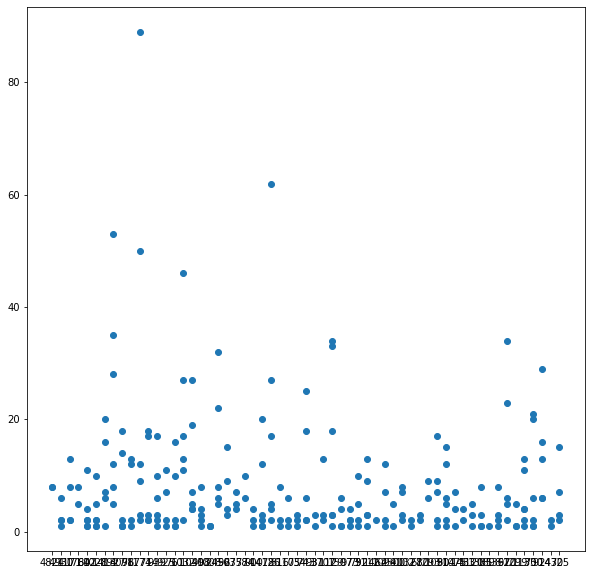

In [144]:
mat.pyplot.figure(figsize=(10, 10))
mat.pyplot.scatter(df_amostras_percentual_cruzamento['RENDA_MENSAL_2010'],df_amostras_percentual_cruzamento['QTD_AMOSTRAS_BAC_PRESENTES'])
mat.pyplot.show()

In [ ]:
#mat.pyplot.bar(df_dados_soc_economicos['BAIRRO'],df_dados_soc_economicos['RENDA_MENSAL_2010'],width=2)